In [ ]:
#| default_exp tbats

# TBATS model 

In [ ]:
#| export
import warnings
from functools import partial
from itertools import product

import numpy as np
import pandas as pd
import scipy.linalg
import statsmodels.api as sm
from numba import njit
from numpy.polynomial.polynomial import Polynomial
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler

from statsforecast.arima import auto_arima_f
from statsforecast.utils import NOGIL, CACHE

/Users/marianamenchero/Documents/statsforecast/statsforecast/core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

from statsforecast.utils import AirPassengers as ap

## Load data 

## Functions 

### find_harmonics

In [ ]:
#| exporti
def find_harmonics(y, m):

    # Compute a 2 x m moving average to estimate the trend 
    window_size = 2 * m
    data = pd.DataFrame({'value': y})
    f_t = data['value'].rolling(window = window_size, center = True).mean()
    
    # Obtain an approximation of seasonal component using z_t = y_t - f_t 
    data['f_t'] = f_t
    data['z_t'] = data['value']-data['f_t']

    # Drop missing values (due to the moving average)
    data.dropna(inplace = True) 

    if data.empty:
        return 1

    # Approximate the seasonal component using trigonometric terms
    t = np.arange(len(data))
    if m % 2 == 0: 
        max_harmonics = int(m/2)
    else: 
        max_harmonics = int((m-1)/2)

    max_harmonics = min(max_harmonics, len(data))
    
    aic = np.inf
    num_harmonics = 0
    for h in range(1,max_harmonics+1): 
        columns = []
        for i in range(1, h+1):
            data[f'cos_{i}'] = np.cos(2*np.pi*i*t/m)
            data[f'sin_{i}'] = np.sin(2*np.pi*i*t/m)
            columns.extend([f'cos_{i}', f'sin_{i}'])
        
        # Perform regression to estimate the coefficients
        X = data[columns]
        y = data['z_t']
        model = sm.OLS(y, X).fit()
        new_aic = model.aic 

        if new_aic < aic: 
            aic = new_aic
            num_harmonics = h  
        else: 
            break

    if num_harmonics == 0: 
        num_harmonics += 1 
    
    return num_harmonics

### initial_parameters 

In [ ]:
#| exporti
def initial_parameters(seasonal_periods, k_vector, use_trend, use_damped_trend, ar_coeffs, ma_coeffs): 

    alpha = 0.09 

    if use_trend: 
        adj_beta = 1 
        beta = 0.05
        b = 0 
        if use_damped_trend: 
            phi = 0.999 
        else: 
            phi = 1.0
    else: 
        adj_beta = 0 
        beta = None 
        b = None 
        phi = None
        use_damped_trend = False

    gamma_one_v = np.zeros(len(k_vector))
    gamma_two_v = np.zeros(len(k_vector))
    s_vector = np.zeros(2*np.sum(k_vector))

    if ar_coeffs is not None: 
        d_vector = np.zeros(len(ar_coeffs))
    else: 
        d_vector = None
    if ma_coeffs is not None:
        epsilon_vector = np.zeros(len(ma_coeffs))  
    else: 
        epsilon_vector = None 
    return alpha, adj_beta, beta, b, phi, gamma_one_v, gamma_two_v, s_vector, d_vector, epsilon_vector 

### makeXMatrix

In [ ]:
#| exporti
def makeXMatrix(b, s_vector, d_vector, epsilon_vector): 

    # x = (l_t, b_t, s_vector, d_vector, epsilon_vector)
    x = np.array([0.0]) 
    if b is not None: 
        x = np.append(x, b)
    if s_vector is not None: 
        x = np.concatenate((x, s_vector))
    if d_vector is not None: 
        x = np.concatenate((x, d_vector)) 
    if epsilon_vector is not None: 
        x = np.concatenate((x, epsilon_vector))
    
    return x

### findPQ

In [ ]:
#| exporti
def findPQ(ar_coeffs, ma_coeffs):
    p = 0 if ar_coeffs is None else len(ar_coeffs)
    q = 0 if ma_coeffs is None else len(ma_coeffs)
    return p, q

### makeTBATSWMatrix

In [ ]:
#| exporti
def makeTBATSWMatrix(phi, k_vector, ar_coeffs, ma_coeffs, tau):
    # w_transpose = (1, phi, a, varphi, theta)
    p, q = findPQ(ar_coeffs, ma_coeffs)
    adj_phi = 0 
    numCols = 1

    if phi is not None: 
        adj_phi += 1
        numCols += 1

    numCols += tau + p + q

    w_transpose = np.zeros((1, numCols))

    position = adj_phi
    for k in k_vector: 
        w_transpose[0, position + 1 : position + 1 + k] = 1
        position += 2 * k

    w_transpose[0, 0] = 1 

    if phi is not None:
        w_transpose[0, 1] = phi

    if ar_coeffs is not None: 
        w_transpose[0, adj_phi+tau+1:adj_phi+tau+p+1] = ar_coeffs

    if ma_coeffs is not None:
        w_transpose[0, adj_phi+tau+p+1:adj_phi+tau+p+q+1] = ma_coeffs

    return w_transpose

### makeTBATSGMatrix 

In [ ]:
#| exporti
def makeTBATSGMatrix(k_vector, alpha, adj_beta, beta, gamma_one_v, gamma_two_v, p, q, tau):
    
    # g = (alpha, beta, gamma_bold, 1, 0_{p-1}, 1, 0_{q-1})
    g = np.zeros((1+adj_beta+2*np.sum(k_vector)+p+q,1))

    g[0,0] = alpha 

    if beta is not None: 
        g[1,0] = beta 

    gamma_bold = np.ones((1, 2*np.sum(k_vector)))
    endPos = 0 
    for k, gamma_one, gamma_two in zip(k_vector, gamma_one_v, gamma_two_v):
        gamma_bold[0, endPos:endPos+k] = gamma_one
        gamma_bold[0, endPos+k:endPos+2*k] = gamma_two
        endPos += 2*k

    g[1+adj_beta:1+adj_beta+gamma_bold.shape[1],0] = gamma_bold

    if p != 0: 
        g[1+adj_beta+tau,0] = 1 
    if q != 0: 
        g[1+adj_beta+tau+p,0] = 1

    return g, gamma_bold

### makeTBATSFMatrix 

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def makeTBATSFMatrix(phi, tau, alpha, beta, ar_coeffs, ma_coeffs, gamma_bold, seasonal_periods, k_vector):
    # Alpha row 
    F = np.array([[1.0]])
    if phi is not None: 
        F = np.hstack((F, np.array([[phi]])))
    F = np.hstack((F, np.zeros((1,tau))))
    if ar_coeffs is not None: 
        alpha_varphi = alpha*ar_coeffs
        alpha_varphi = alpha_varphi.reshape((1,len(alpha_varphi)))
        F = np.hstack((F, alpha_varphi))
    if ma_coeffs is not None: 
        alpha_theta = alpha*ma_coeffs
        alpha_theta = alpha_theta.reshape((1,len(alpha_theta)))
        F = np.hstack((F, alpha_theta))
    
    # Beta row 
    if beta is not None: 
        beta_row = np.array([[0.0, phi]])
        beta_row = np.hstack((beta_row, np.zeros((1,tau))))
        if ar_coeffs is not None: 
            beta_varphi = beta*ar_coeffs
            beta_varphi = beta_varphi.reshape((1,len(beta_varphi)))
            beta_row = np.hstack((beta_row, beta_varphi))
        if ma_coeffs is not None: 
            beta_theta = beta*ma_coeffs
            beta_theta = beta_theta.reshape((1,len(beta_theta)))
            beta_row = np.hstack((beta_row, beta_theta))
        F = np.vstack((F, beta_row))

    # Seasonal row 
    seasonal_row = np.zeros((tau,1))

    if phi is not None: 
        seasonal_row = np.hstack((seasonal_row, np.zeros((tau,1))))

    A = np.zeros((tau, tau))
    pos = 0
    for k, period in zip(k_vector, seasonal_periods):
        t = 2 * np.pi * np.arange(1, k + 1) / period
        ck = np.diag(np.cos(t))
        sk = np.diag(np.sin(t))
        top = np.hstack((ck, sk))
        bottom = np.hstack((-sk, ck)) 
        Ak = np.vstack((top, bottom))
        A[pos:pos+2*k,pos:pos+2*k] = Ak
        pos += 2*k
    seasonal_row = np.hstack((seasonal_row, A))

    if ar_coeffs is not None: 
        varphi = ar_coeffs.reshape((1, ar_coeffs.shape[0]))
        B = np.dot(np.transpose(gamma_bold), varphi)
        seasonal_row = np.hstack((seasonal_row, B))

    if ma_coeffs is not None: 
        theta = ma_coeffs.reshape((1, ma_coeffs.shape[0]))
        C = np.dot(np.transpose(gamma_bold), theta)
        seasonal_row = np.hstack((seasonal_row, C))

    F = np.vstack((F, seasonal_row))

    # ARMA submatrix 
    if ar_coeffs is not None:
        p = len(ar_coeffs)
        ar_rows = np.zeros((p, 1))
        
        if phi is not None:
            ar_rows = np.hstack((ar_rows, ar_rows))
            
        ar_seasonal_zeros = np.zeros((p, tau)) # seasonal part
        ar_rows = np.hstack((ar_rows, ar_seasonal_zeros))
        
        ident = np.eye(p - 1)
        ident = np.hstack((ident, np.zeros(((p - 1), 1))))

        ar_part = np.vstack((ar_coeffs.reshape((1, ar_coeffs.shape[0])), ident))
        ar_rows = np.hstack((ar_rows, ar_part))
        
        if ma_coeffs is not None:
            q = len(ma_coeffs)
            ma_in_ar = np.zeros((p, q))
            ma_in_ar[0, :] = ma_coeffs
            ar_rows = np.hstack((ar_rows, ma_in_ar))
        
        F = np.vstack((F, ar_rows))

    if ma_coeffs is not None:
        q = len(ma_coeffs)
        ma_rows = np.zeros((q, 1))
        
        if phi is not None:
            ma_rows = np.hstack((ma_rows, ma_rows))

        ma_seasonal = np.zeros((q, tau))
        ma_rows = np.hstack((ma_rows, ma_seasonal))
        
        if ar_coeffs is not None:
            p = len(ar_coeffs)
            ar_in_ma = np.zeros((q, p))
            ma_rows = np.hstack((ma_rows, ar_in_ma))
        
        ident = np.eye(q - 1)
        ident = np.hstack((ident, np.zeros(((q - 1), 1))))
        ma_part = np.vstack((np.zeros((1, q)), ident))
        ma_rows = np.hstack((ma_rows, ma_part))
        
        F = np.vstack((F, ma_rows))
    
    return F

### calcTBATSFaster 

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def calcTBATSFaster(y_trans, w_transpose, g, F, x_nought): 

    n = y_trans.shape[0]
    
    yhat = np.zeros((1,n))
    e = np.zeros((1,n))
    x = np.zeros((n, len(x_nought)))

    yhat[0,0] = np.dot(w_transpose[0], x_nought)
    e[0,0] = y_trans[0]-yhat[0,0] 
    x[0] = np.dot(F, x_nought)+(g[:, 0] * e[0,0])

    for j in range(1,y_trans.shape[0]): 
        yhat[:, j] = np.dot(w_transpose[0], x[j-1])
        e[0,j] = y_trans[j]-yhat[0,j]
        x[j] = np.dot(F, x[j-1]) + g[:, 0] * e[0,j]
        
    return yhat, e, x

### extract_params

In [ ]:
#| exporti
def extract_params(params, use_boxcox, use_trend, use_damped_trend, use_arma_errors, seasonal_periods, p, q):
    if use_boxcox: 
        BoxCox_lambda = params[0]
        alpha = params[1]
        index = 2 
    else: 
        BoxCox_lambda = None 
        alpha = params[0]
        index = 1
    if use_trend: 
        beta = params[index]
        index += 1
        if use_damped_trend: 
            phi = params[index]
            index += 1
        else: 
            phi = 1.0
    else: 
        beta = None
        phi = None
    gamma_one_v = params[index:index+len(seasonal_periods)]
    gamma_two_v = params[index+len(seasonal_periods):index+2*len(seasonal_periods)]
    index += 2*len(seasonal_periods)
    ar_coeffs = None 
    ma_coeffs = None    
    if use_arma_errors: # if arma_errors = True, then p or q must be non-zero 
        if p != 0 and q != 0: 
            ar_coeffs = params[index:index+p]
            ma_coeffs = params[index+p:index+p+q]
        elif p != 0: 
            ar_coeffs = params[index:index+p]
        elif q != 0:
            ma_coeffs = params[index:index+q]
    return BoxCox_lambda, alpha, beta, phi, gamma_one_v, gamma_two_v, ar_coeffs, ma_coeffs

### updateTBATSWMatrix

In [ ]:
#| exporti
def updateTBATSWMatrix(w_transpose, phi, tau, ar_coeffs, ma_coeffs, p, q): 
    adjBeta = 0 

    if phi is not None: 
        adjBeta = 1 
        w_transpose[0,1] = phi 

    if p != 0: 
        w_transpose[0, adjBeta+tau+1:adjBeta+tau+p+1] = ar_coeffs
        if q != 0: 
            w_transpose[0, adjBeta+tau+p+1:adjBeta+tau+p+q+1] = ma_coeffs
    elif q != 0:
        # here p = 0 
        w_transpose[0, adjBeta+tau+1:adjBeta+tau+q+1] = ma_coeffs
    
    return(w_transpose)

### updateTBATSGMatrix 

In [ ]:
#| exporti
def updateTBATSGMatrix(g, gamma_bold, alpha, beta, k_vector, gamma_one_v, gamma_two_v):
    # This function also updates gamma_bold  
    adjBeta = 0 
    g[0,0] = alpha 
    
    if beta is not None: 
        g[1,0] = beta 
        adjBeta = 1 

    endPos = 0
    for k, gamma_one, gamma_two in zip(k_vector, gamma_one_v, gamma_two_v):
        gamma_bold[0, endPos:endPos+k] = gamma_one
        gamma_bold[0, endPos+k:endPos+2*k] = gamma_two
        endPos += 2*k
    
    g[(adjBeta+1):(adjBeta+gamma_bold.shape[1]+1), 0] = gamma_bold.ravel()
    
    return g 

### updateTBATSFMatrix 

In [ ]:
#| exporti
def updateTBATSFMatrix(F, phi, alpha, beta, gamma_bold, ar_coeffs, ma_coeffs, p, q, tau):
    if beta is not None: 
        F[0,1] = phi
        F[1,1] = phi
        betaAdjust = 1
    else:
        betaAdjust = 0 
    if ar_coeffs is not None:
        F[0, (betaAdjust+tau+1):(betaAdjust+tau+p+1)] = alpha*ar_coeffs
        if betaAdjust == 1:  
            F[1, (betaAdjust+tau+1):(betaAdjust+tau+p+1)] = beta*ar_coeffs 
        if tau > 0: 
            B = np.dot(gamma_bold.reshape(-1,1), ar_coeffs.reshape(1, -1))
            F[(1+betaAdjust):(betaAdjust+tau+1), (betaAdjust+tau+1):(betaAdjust+tau+p+1)] = B 
        F[betaAdjust+tau+1,(betaAdjust+tau+1):(betaAdjust+tau+p+1)] = ar_coeffs 
    if ma_coeffs is not None: 
        F[0, (betaAdjust+tau+p+1):(betaAdjust+tau+p+q+1)] = alpha*ma_coeffs 
        if betaAdjust == 1:  
            F[1, (betaAdjust+tau+p+1):(betaAdjust+tau+p+q+1)] = beta*ma_coeffs
        if tau > 0: 
            C = np.dot(gamma_bold.reshape(-1,1), ma_coeffs.reshape(1, -1))
            F[(1+betaAdjust):(betaAdjust+tau+1), (betaAdjust+tau+p+1):(betaAdjust+tau+p+q+1)] = C 
        if ar_coeffs is not None: 
            F[betaAdjust+tau+1,(betaAdjust+tau+p+1):(betaAdjust+tau+p+q+1)] = ma_coeffs 

    return F 

### checkAdmissibility

In [ ]:
#| exporti
def checkAdmissibility(BoxCox_lambda, bc_lower_bound, bc_upper_bound, alpha, beta, phi, ar_coeffs, ma_coeffs, D): 
    if BoxCox_lambda is not None: 
        if (BoxCox_lambda < bc_lower_bound) or (BoxCox_lambda > bc_upper_bound): 
            return False

    if phi is not None: 
        if (phi < 0.8) or (phi > 1):
            return False 
            
    if ar_coeffs is not None:
        ar_lags = np.where(np.abs(ar_coeffs) > 1e-08)[0]
        if len(ar_lags) > 0:
            pval = max(ar_lags) + 1  
            poly_coeffs = [1] + [-coef for coef in ar_coeffs[:pval]]
            roots = Polynomial(poly_coeffs).roots()
            if np.min(np.abs(roots)) < 1 + 1e-2:
                return False
            
    if ma_coeffs is not None:
        ma_lags = np.where(np.abs(ma_coeffs) > 1e-08)[0]
        if len(ma_lags) > 0:
            qval = max(ma_lags) + 1  
            poly_coeffs = [1] + list(ma_coeffs[:qval])
            roots = Polynomial(poly_coeffs).roots()
            if np.min(np.abs(roots)) < 1 + 1e-2:
                return False

    D_eigen_values = scipy.linalg.eig(D, right=False)
    
    return np.all(abs(D_eigen_values) < 1+1e-2)

### calcLikelihoodTBATS

In [ ]:
#| exporti
def calcLikelihoodTBATS(params, use_boxcox, use_trend, use_damped_trend, use_arma_errors, y, y_trans, seasonal_periods, k_vector, tau, w_transpose, F, g, gamma_bold, x_nought, x_nought_untransformed, bc_lower_bound, bc_upper_bound, p, q): 
    BoxCox_lambda, alpha, beta, phi, gamma_one_v, gamma_two_v, ar_coeffs, ma_coeffs = extract_params(params, use_boxcox, use_trend, use_damped_trend, use_arma_errors, seasonal_periods, p, q)

    w_transpose = updateTBATSWMatrix(w_transpose, phi, tau, ar_coeffs, ma_coeffs, p, q) 
    g = updateTBATSGMatrix(g, gamma_bold, alpha, beta, k_vector, gamma_one_v, gamma_two_v)
    F = updateTBATSFMatrix(F, phi, alpha, beta, gamma_bold, ar_coeffs, ma_coeffs, p, q, tau)

    if use_boxcox:
        x_nought = boxcox(x_nought_untransformed, BoxCox_lambda)
        y_trans = boxcox(y, BoxCox_lambda)
    _, e, _ = calcTBATSFaster(y_trans, w_transpose, g, F, x_nought)

    n = len(y_trans)
    if use_boxcox: 
        log_likelihood = n*np.log(np.nansum(e**2))-2*(BoxCox_lambda-1)*np.nansum(np.log(y)) 
    else: 
        log_likelihood = n*np.log(np.nansum(e**2))

    D = F-np.dot(g, w_transpose)

    if checkAdmissibility(BoxCox_lambda, bc_lower_bound, bc_upper_bound, alpha, beta, phi, ar_coeffs, ma_coeffs, D): 
        return log_likelihood 
    else: 
        return 10**20

## TBATS model 

### tbats_model_generator 

In [ ]:
#| exporti
def tbats_model_generator(y, seasonal_periods, k_vector, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors, ar_coeffs, ma_coeffs): 

    # Initial Box-Cox transformation (if required)
    if use_boxcox: 
        BoxCox_lambda = 0 # This is the initial value used in the thesis 
        y_trans = boxcox(y, BoxCox_lambda)
    else: 
        BoxCox_lambda = None
        y_trans = y 

    p, q = findPQ(ar_coeffs, ma_coeffs)

    # select starting params 
    alpha, adj_beta, beta, b, phi, gamma_one_v, gamma_two_v, s_vector, d_vector, epsilon_vector = initial_parameters(seasonal_periods, k_vector, use_trend, use_damped_trend, ar_coeffs, ma_coeffs)

    # seed states 
    x_nought = makeXMatrix(b, s_vector, d_vector, epsilon_vector)

    # tau 
    tau = 2*np.sum(k_vector)

    # Create w_transpose, g, and F matrices 
    w_transpose = makeTBATSWMatrix(phi, k_vector, ar_coeffs, ma_coeffs, tau)
    g, gamma_bold = makeTBATSGMatrix(k_vector, alpha, adj_beta, beta, gamma_one_v, gamma_two_v, p, q, tau)
    F = makeTBATSFMatrix(phi, tau, alpha, beta, ar_coeffs, ma_coeffs, gamma_bold, seasonal_periods, k_vector)
    D = F - np.dot(g, w_transpose)

    # Find seed states 
    _, e, x = calcTBATSFaster(y_trans, w_transpose, g, F, x_nought)

    w_tilda_transpose = np.zeros((y.shape[0], w_transpose.shape[1]))
    w_tilda_transpose[0,:] = w_transpose

    for k in range(1, w_tilda_transpose.shape[0]): 
        w_tilda_transpose[k,:] = np.dot(w_tilda_transpose[k-1,:], D)

    if p != 0 or q!= 0: 
        end_cut = w_tilda_transpose.shape[1] 
        start_cut = end_cut-(p+q)    
        new_cols = np.arange(0, start_cut, 1)
        w_tilda_transpose = w_tilda_transpose[:, new_cols]

    condition_number = np.linalg.cond(w_tilda_transpose)
    if np.isinf(condition_number): 
        scaler = StandardScaler()
        w_tilda_transpose_scaled = scaler.fit_transform(w_tilda_transpose)
        model = sm.OLS(e.reshape((e.shape[1],1)), w_tilda_transpose_scaled).fit()
        x_nought_scaled = model.params
        x_nought = x_nought_scaled/scaler.scale_
    else: 
        model = sm.OLS(e.reshape((e.shape[1],1)), w_tilda_transpose).fit()
        x_nought = model.params

    if (p != 0) or (q != 0):
        arma_seed_states = np.zeros((p+q,))
        x_nought = np.concatenate((x_nought, arma_seed_states))

    # Optimization 
    # Create vector with parameters 
    if use_boxcox: 
        params = np.concatenate([np.array([BoxCox_lambda]), np.array([alpha])]) 
    else:  
        params = np.array([alpha])
    if beta is not None:
        params = np.concatenate([params, np.array([beta])])
    if phi is not None and phi != 1:
        use_damped_trend = True
        params = np.concatenate([params, np.array([phi])])
    else:
        use_damped_trend = False
    params = np.concatenate([params, gamma_one_v, gamma_two_v])
    if ar_coeffs is not None: 
        params = np.concatenate([params, ar_coeffs])
    if ma_coeffs is not None: 
        params = np.concatenate([params, ma_coeffs])
    if use_boxcox:
        x_nought_untransformed = inv_boxcox(x_nought, BoxCox_lambda)
    else:
        x_nought_untransformed = x_nought
    
    objective_fn = partial(
        calcLikelihoodTBATS,
        use_boxcox=use_boxcox,
        use_trend=use_trend,
        use_damped_trend=use_damped_trend,
        use_arma_errors=use_arma_errors,
        y=y,
        y_trans=y_trans,
        seasonal_periods=seasonal_periods,
        k_vector=k_vector,
        tau=tau,
        w_transpose=w_transpose,
        F=F,
        g=g,
        gamma_bold=gamma_bold,
        x_nought=x_nought,
        x_nought_untransformed=x_nought_untransformed,
        bc_lower_bound=bc_lower_bound,
        bc_upper_bound=bc_upper_bound,
        p=p,
        q=q,
    )
    # Solve optimization problem
    optim_params = minimize(objective_fn, params, method = 'Nelder-Mead').x

    optim_BoxCox_lambda, optim_alpha, optim_beta, optim_phi, optim_gamma_one_v, optim_gamma_two_v, optim_ar_coeffs, optim_ma_coeffs = extract_params(optim_params, use_boxcox, use_trend, use_damped_trend, use_arma_errors, seasonal_periods, p, q)
    
    w_transpose = updateTBATSWMatrix(w_transpose, optim_phi, tau, optim_ar_coeffs, optim_ma_coeffs, p, q)
    g = updateTBATSGMatrix(g, gamma_bold, optim_alpha, optim_beta, k_vector, optim_gamma_one_v, optim_gamma_two_v)
    F = updateTBATSFMatrix(F, optim_phi, optim_alpha, optim_beta, gamma_bold, optim_ar_coeffs, optim_ma_coeffs, p, q, tau)

    if use_boxcox:
        y_trans = boxcox(y, optim_BoxCox_lambda)

    fitted, errors, x = calcTBATSFaster(y_trans, w_transpose, g, F, x_nought)

    sigma2 = np.sum(errors*errors)/len(y_trans)

    # Calculate log-likelihood 
    if use_boxcox: 
        log_likelihood = len(y_trans)*np.log(np.nansum(errors**2))-2*(optim_BoxCox_lambda-1)*np.nansum(np.log(y)) 
    else: 
        log_likelihood = len(y_trans)*np.log(np.nansum(errors**2))

    kval = len(optim_params)+x_nought.shape[0]
    aic = log_likelihood+2*kval 

    res = {
        'fitted': fitted, 
        'errors': errors, 
        'sigma2': sigma2, 
        'aic': aic,
        'optim_params': optim_params,
        'F': F, 
        'w_transpose': w_transpose,
        'g': g,
        'x': x,
        'k_vector': k_vector,
        'BoxCox_lambda': optim_BoxCox_lambda,
        'p': p, 
        'q': q
    }

    return res 

### tbats_model 

In [ ]:
#| export
def tbats_model(y, seasonal_periods, k_vector, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors): 

    # First model - No ARMA errors 
    ar_coeffs = None 
    ma_coeffs = None 

    best_model = tbats_model_generator(y, seasonal_periods, k_vector, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors, ar_coeffs, ma_coeffs)
    best_model['description'] = {
        'use_boxcox': use_boxcox, 
        'use_trend': use_trend,
        'use_damped_trend': use_damped_trend,
        'use_arma_errors': False 
    }

    # Second model - ARMA errors 
    if use_arma_errors: 
        errors = best_model['errors'][0] # ARMA errors from first model 
        with np.errstate(invalid="ignore"):
            fit = auto_arima_f(errors, max_d=0, seasonal=False)
        p, q = fit['arma'][:2]
        if p != 0:
            ar_coeffs = np.zeros(p)
        else:
            ar_coeffs = None
        if q != 0:
            ma_coeffs = np.zeros(q)
        else:
            ma_coeffs = None

        model_arma_errors = tbats_model_generator(y, seasonal_periods, k_vector, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors, ar_coeffs, ma_coeffs)

        if model_arma_errors['aic'] < best_model['aic']: # inequality must be strict to prevent use_arma_errors = True when p = q = 0
            best_model = model_arma_errors
            best_model['description'] = {
                'use_boxcox': use_boxcox, 
                'use_trend': use_trend,
                'use_damped_trend': use_damped_trend,
                'use_arma_errors': True 
            }
            
    return best_model 

### tbats_selection 

In [ ]:
#| export
def tbats_selection(y, seasonal_periods, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors):
    
    # Check for banned parameter combinations 
    if (not use_trend) and use_damped_trend: 
        raise ValueError("Can't use damped trend without trend")

    # Sort seasonal periods 
    seasonal_periods = np.sort(seasonal_periods)

    # Check if there are missing values 
    indices = np.where(np.isnan(y))[0]
    if len(indices) > 0: 
        max_index = indices[-1]
        y = y[max_index+1:len(y)]

    # Check if there are negative values
    if np.any(y < 0): 
        use_boxcox = False 

    # Check if there is a trend
    adf = adfuller(y, regression = 'ct')
    if adf[1] <= 0.05: 
        warnings.warn('The time series is trend-stationary, disabling trend components.')
        use_trend = False
        use_damped_trend = False
    else: 
        use_trend = True

    # Choose the number of harmonics 
    k_vector = np.array([find_harmonics(y, m) for m in seasonal_periods])

    # Select combinations to try out 
    if use_boxcox is None: 
        B = [True, False]
    else: 
        B = [use_boxcox]

    if use_trend: 
        if use_damped_trend is None: 
            T = [[True, True], [True, False]]
        else: 
            T = [[True, use_damped_trend]]
    else: 
        T = [[False, False]]

    A = [use_arma_errors] 

    combinations = [(b,t,a) for b,t,a in product(B,T,A)]

    for k in range(len(combinations)): 
        boxcox  = combinations[k][0]
        trend = combinations[k][1][0]
        damped_trend = combinations[k][1][1] 
        arma_errors = combinations[k][2]

        if k == 0: 
            mod = tbats_model(y, seasonal_periods, k_vector, boxcox, bc_lower_bound, bc_upper_bound, trend, damped_trend, arma_errors)
        else:
            new_mod = tbats_model(y, seasonal_periods, k_vector, boxcox, bc_lower_bound, bc_upper_bound, trend, damped_trend, arma_errors)
            if new_mod['aic'] < mod['aic']: 
                mod = new_mod 

    return mod 

### tbats_forecast

In [ ]:
#| export
def tbats_forecast(mod, h): # this function is the same as bats_forecast
    fcst = np.zeros(h)
    xx = np.zeros((h, mod['x'].shape[1]))
    w = mod['w_transpose'][0]

    fcst[0] = np.dot(w, mod['x'][-1])
    xx[0] = np.dot(mod['F'], mod['x'][-1])

    if h > 1: 
        for t in range(1,h):
            xx[t] = np.dot(mod['F'], xx[t-1])
            fcst[t] = np.dot(w, xx[t-1])

    res = {'mean': fcst}

    return res

In [ ]:
#| exporti
def _compute_sigmah(obj, h): 
    """
    Computes the sigmah requiered for prediction intervals
    """
    var_mult = np.zeros(h)
    var_mult[0] = 1
    if h > 1:
        for j in range(1,h):
            if j == 1:
                f_running = np.eye(obj['F'].shape[1])
            else:
                f_running = np.dot(f_running, obj['F'])
            cj = np.dot(np.dot(obj['w_transpose'][0], f_running), obj['g'][:, 0])
            var_mult[j] = var_mult[j-1]+cj**2
    sigma2h = obj['sigma2']*var_mult    
    sigmah = np.sqrt(sigma2h)
    return sigmah

### Example 

In [ ]:
y = ap
seasonal_periods = np.array([12])

In [ ]:
# Default parameters 
use_boxcox = None
bc_lower_bound = 0
bc_upper_bound = 1
use_trend = None
use_damped_trend = None
use_arma_errors = True

In [ ]:
mod = tbats_selection(y, seasonal_periods, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors) 

In [ ]:
# Values in R
print(mod['aic']) # 1397.015
print(mod['k_vector']) # 5
print(mod['description']) # use_boxcox = TRUE, use_trend = TRUE, use_damped_trend = FALSE, use_arma_errors = FALSE

1397.1255251618845
[5]
{'use_boxcox': True, 'use_trend': True, 'use_damped_trend': False, 'use_arma_errors': False}


In [ ]:
fitted_trans = mod['fitted'].ravel()
if mod['BoxCox_lambda'] is not None:
    fitted_trans = inv_boxcox(fitted_trans, mod['BoxCox_lambda'])    

In [ ]:
h = 24
fcst = tbats_forecast(mod, h)
forecast = fcst['mean']
if mod['BoxCox_lambda'] is not None:
    forecast = inv_boxcox(forecast,  mod['BoxCox_lambda'])

<matplotlib.legend.Legend>

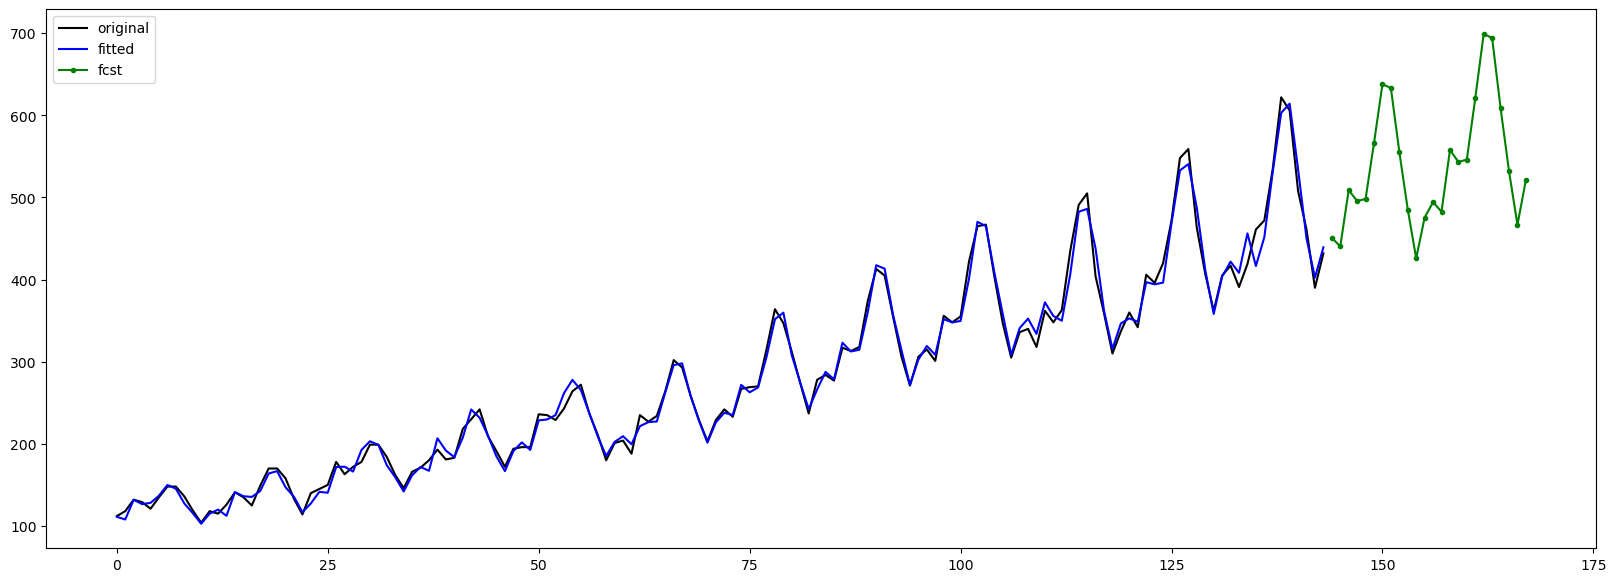

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20,7))
plt.plot(np.arange(0, len(y)), y, color='black', label='original')
plt.plot(np.arange(0, len(y)), fitted_trans, color='blue', label = "fitted")
plt.plot(np.arange(len(y), len(y)+h), forecast, '.-', color = 'green', label = 'fcst')
plt.legend()

### Validation 

In [ ]:
# Electricity consumption 
df = pd.read_csv("https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/PJM_Load_hourly.csv")
df.columns = ["ds", "y"]
df.insert(0, "unique_id", "PJM_Load_hourly")
df["ds"] = pd.to_datetime(df["ds"])
df = df.sort_values(["unique_id", "ds"]).reset_index(drop=True)

df_train = df[:-24]
df_test = df[-24:]

y = df_train["y"].values 
y = y[-2000:]
seasonal_periods = np.array([24, 24*7])

<matplotlib.legend.Legend>

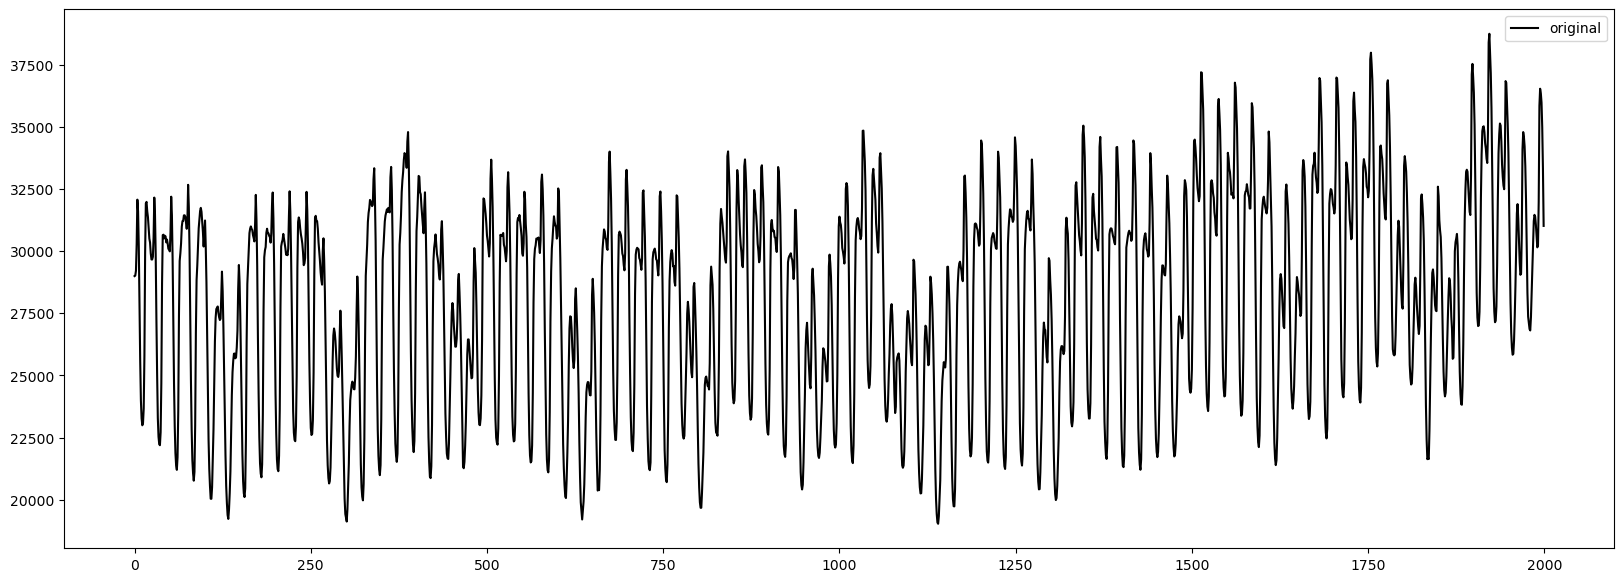

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20,7))
plt.plot(np.arange(0, len(y)), y, color='black', label='original')
plt.legend()

/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:912: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:912: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:912: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:912: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:912: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforecast/arima.py:912: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/Users/marianamenchero/Documents/statsforecast/statsforeca

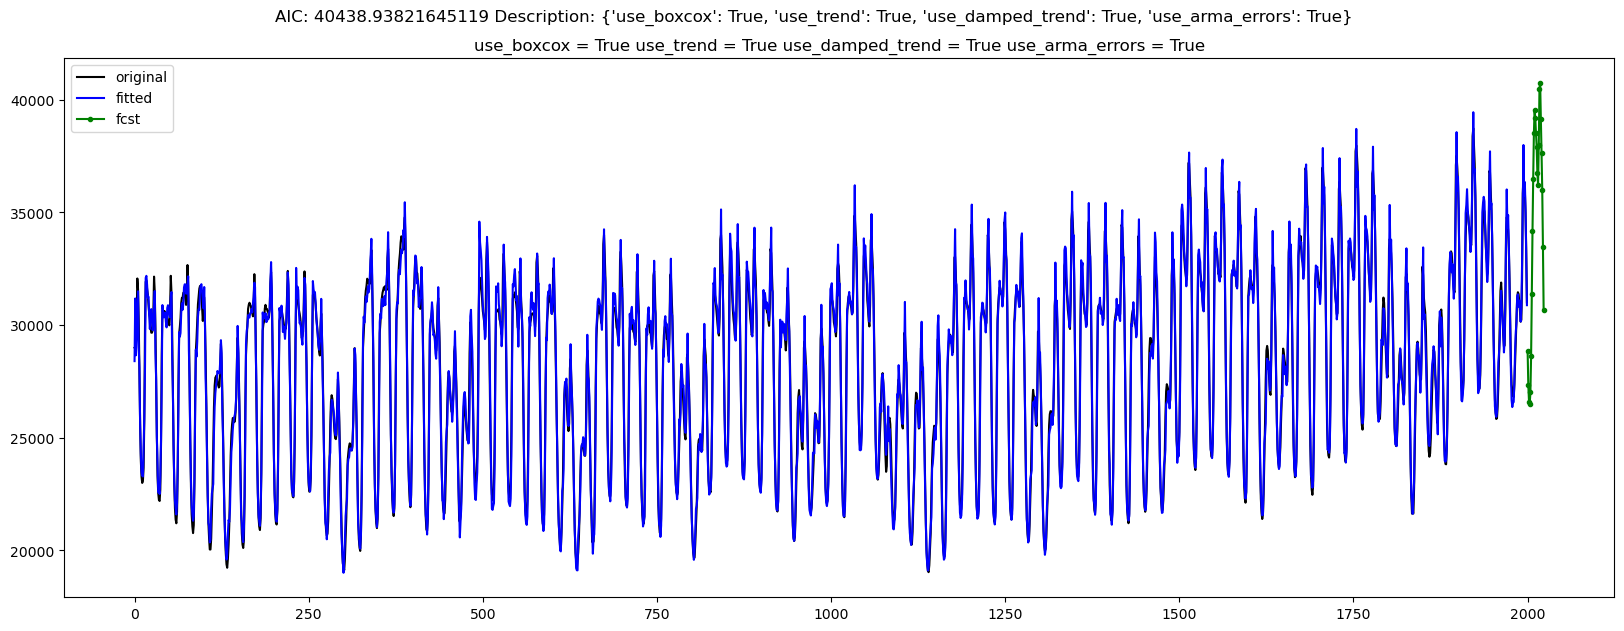

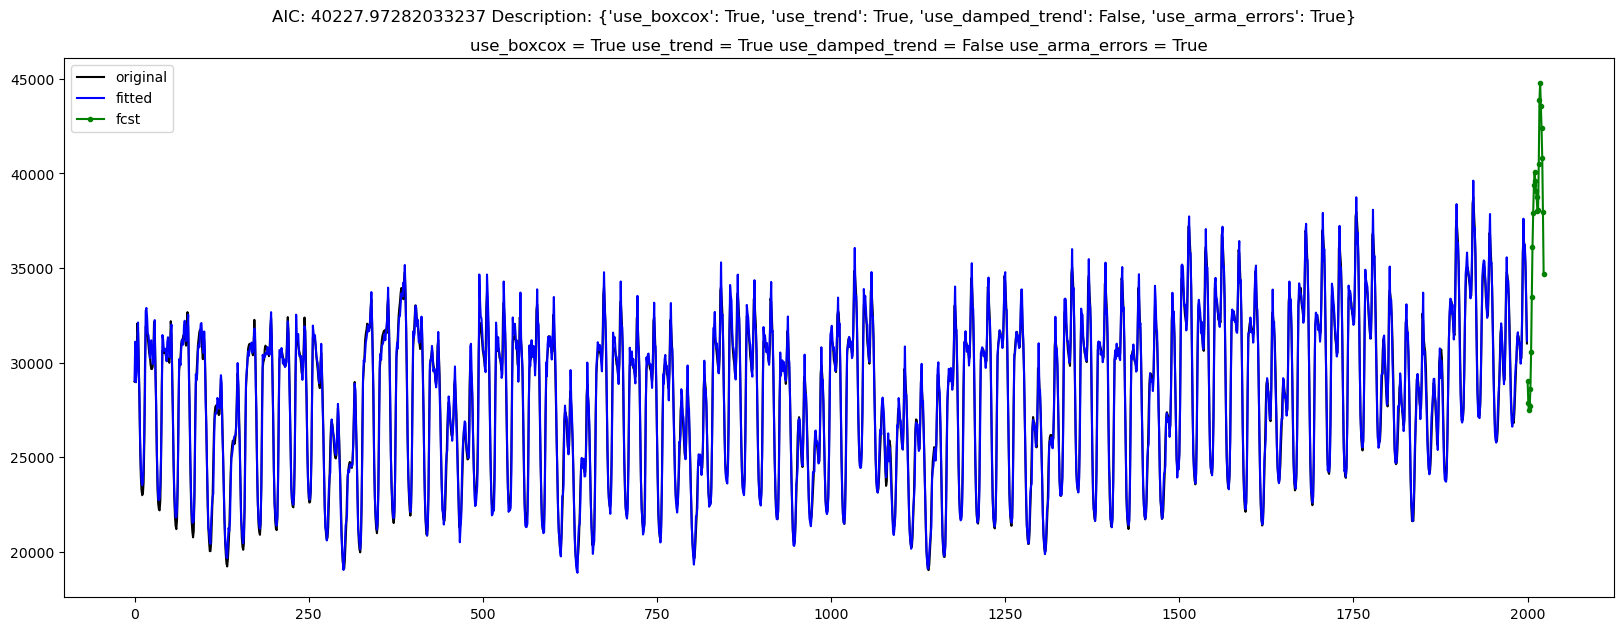

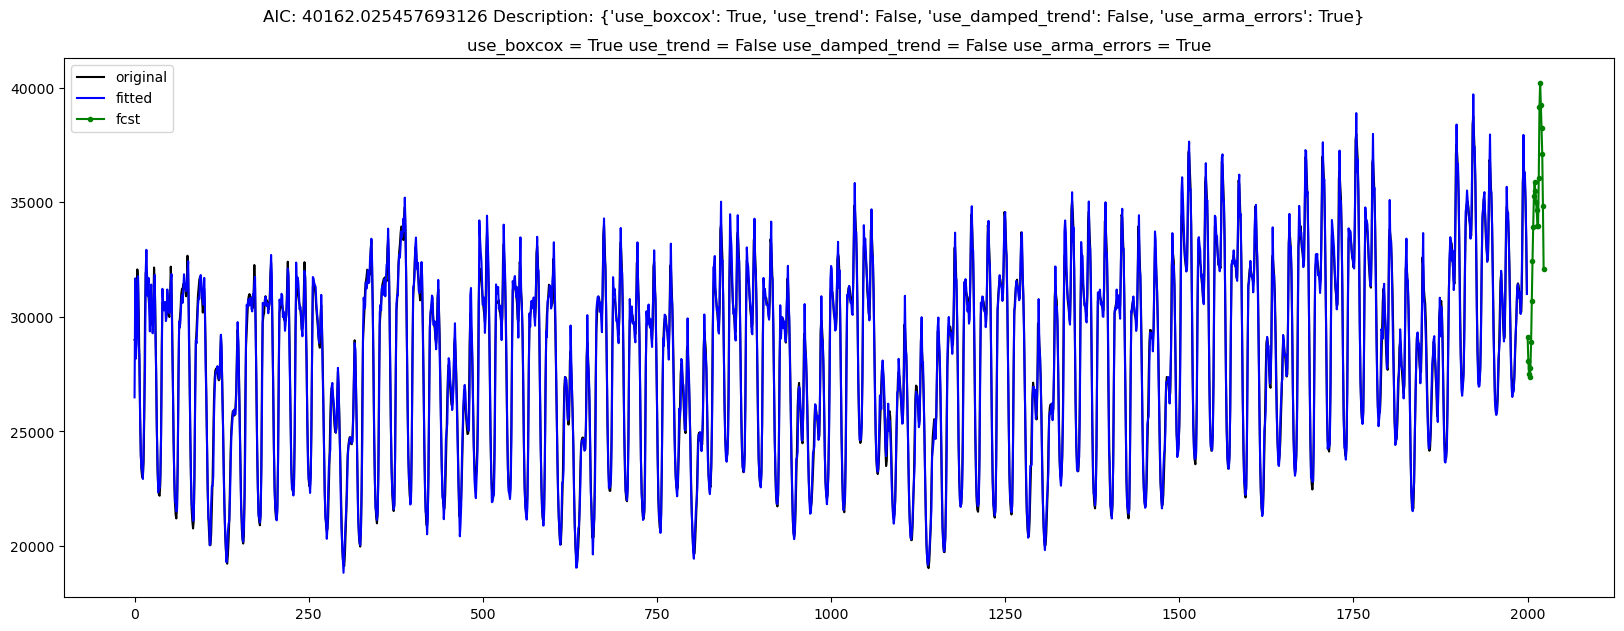

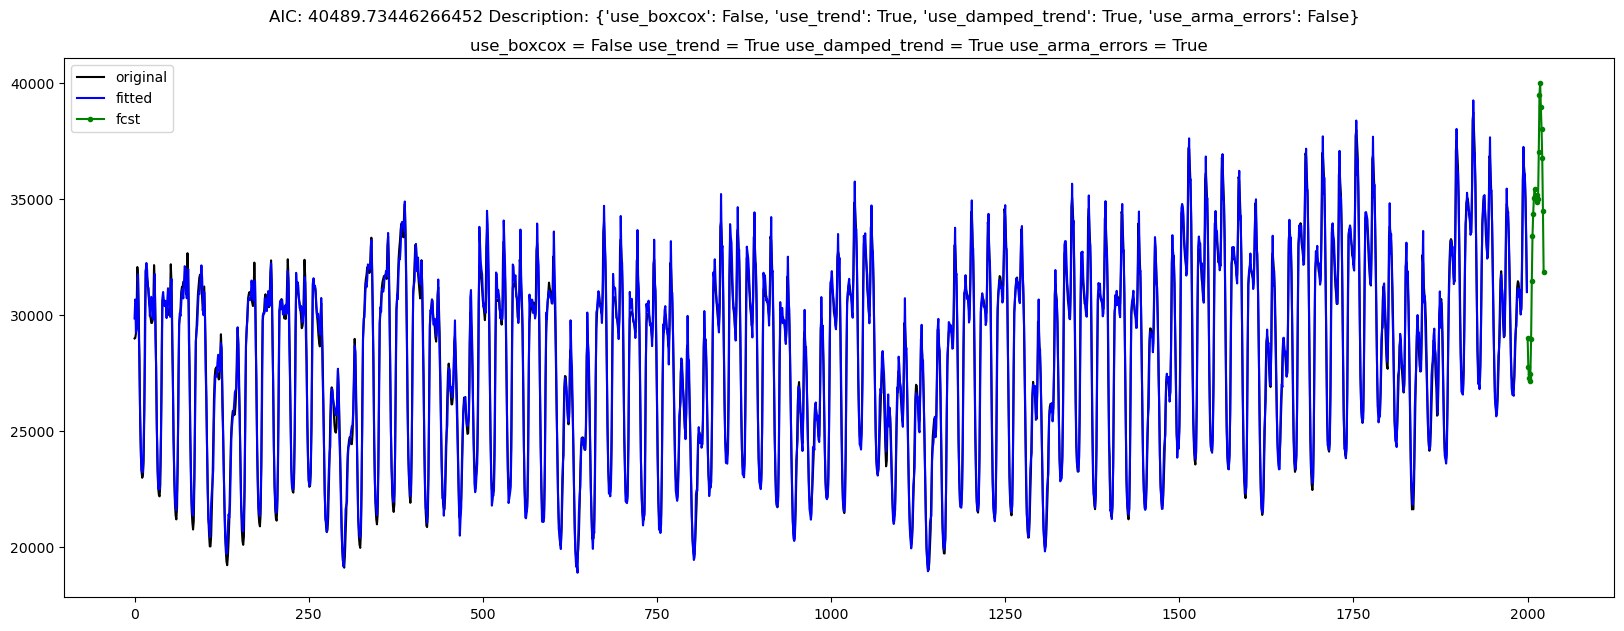

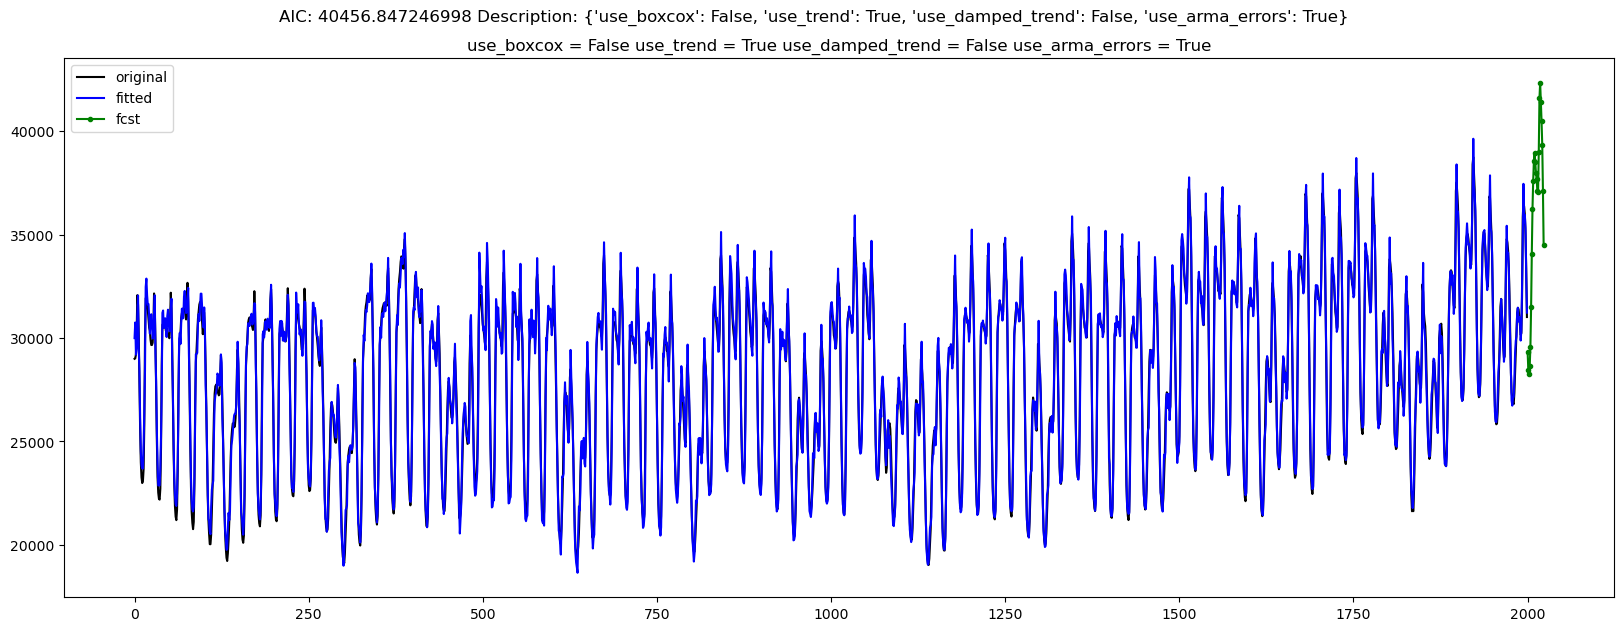

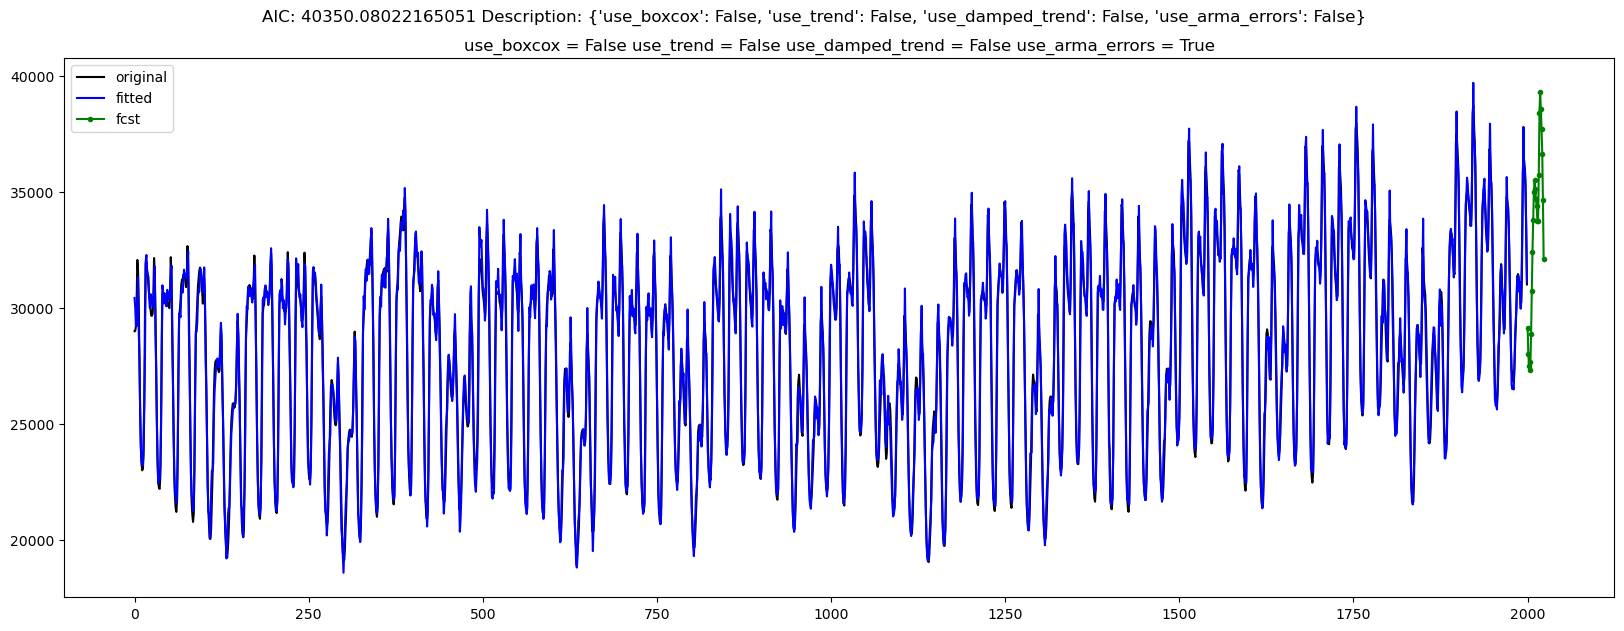

In [ ]:
combinations = [
    [True, True, True, True], 
    [True, True, False, True], 
    [True, False, False, True], 
    [False, True, True, True],
    [False, True, False, True], 
    [False, False, False, True]
]

for k in range(len(combinations)): 
    use_boxcox = combinations[k][0]
    use_trend = combinations[k][1]
    use_damped_trend = combinations[k][2]
    use_arma_errors = combinations[k][3]

    bc_lower_bound = 0 
    bc_upper_bound = 1

    k_vector = np.array([find_harmonics(y, m) for m in seasonal_periods])

    mod = tbats_model(y, seasonal_periods, k_vector, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors)

    fitted_trans = mod['fitted'].ravel()
    if use_boxcox:
        fitted_trans = inv_boxcox(fitted_trans, mod['BoxCox_lambda'])    

    h = 24
    fcst = tbats_forecast(mod, h)
    forecast = fcst['mean']
    if use_boxcox:
        forecast = inv_boxcox(forecast,  mod['BoxCox_lambda'])

    title = "use_boxcox = " + str(combinations[k][0]) + " use_trend = " + str(combinations[k][1]) + " use_damped_trend = " + str(combinations[k][2]) + " use_arma_errors = " + str(combinations[k][3])
    subtitle = "AIC: " + str(mod['aic']) + " Description: " +str(mod['description'])

    fig, ax = plt.subplots(1, 1, figsize = (20,7))
    plt.plot(np.arange(0, len(y)), y, color='black', label='original')
    plt.plot(np.arange(0, len(y)), fitted_trans, color='blue', label = "fitted")
    plt.plot(np.arange(len(y), len(y)+h), forecast, '.-', color = 'green', label = 'fcst')
    plt.legend()
    ax.set_title(title)
    fig.suptitle(subtitle, y = 0.95)